## import

In [1]:
import os
import sys
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

%matplotlib inline

# import cv2
from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add, Dense
from keras.layers.core import Lambda, Reshape, Flatten
from keras.layers.convolutional import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers.pooling import MaxPooling2D, GlobalMaxPooling2D
from keras.layers.merge import concatenate, Dot, Multiply
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img#,save_img
from keras.callbacks import CSVLogger

D:\Anaconda2\envs\py3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import keras
from keras.optimizers import SGD, Adam
from keras.regularizers import l2

## data

In [3]:
# Set some parameters
exp_code = "023"
img_size_ori = 101
img_size_target = 101
im_width = 101
im_height = 101
im_chan = 1
basicpath = './data/'
path_train = basicpath + 'train/'
path_test = basicpath + 'test/'

path_train_images = path_train + 'images/'
path_train_masks = path_train + 'masks/'
path_test_images = path_test + 'images/'

In [4]:
# Loading of training/testing ids and depths

train_df = pd.read_csv("./data/train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("./data/depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

len(train_df)

4000

In [5]:
train_df["images"] = [np.array(load_img("./data/train/images/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

Widget Javascript not detected.  It may not be installed or enabled properly.


In [6]:
train_df["masks"] = [np.array(load_img("./data/train/masks/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

Widget Javascript not detected.  It may not be installed or enabled properly.


In [7]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)

def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

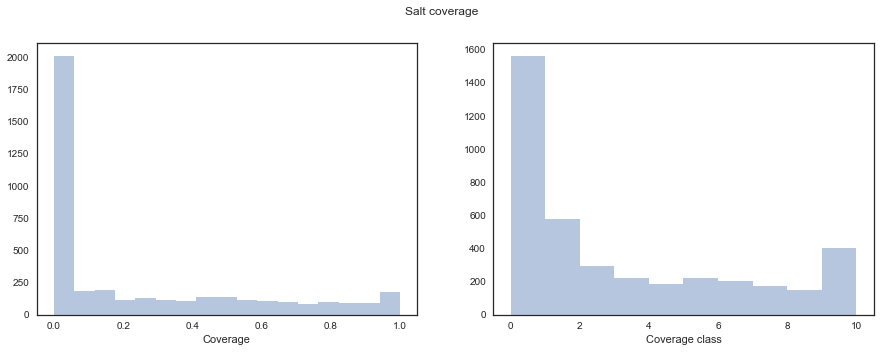

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")
plt.show()

In [9]:
train_df.head()

,z,images,masks,coverage,coverage_class
id,,,,,
575d24d81d,843,"[[0.5254901960784314, 0.5137254901960784, 0.52...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000000,0
a266a2a9df,794,"[[0.3411764705882353, 0.3764705882352941, 0.33...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.504950,6
75efad62c1,468,"[[0.5686274509803921, 0.4666666666666667, 0.32...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.993334,10
34e51dba6a,727,"[[0.5411764705882353, 0.4745098039215686, 0.39...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.149201,2
4875705fb0,797,"[[0.06666666666666667, 0.0784313725490196, 0.0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.042839,1


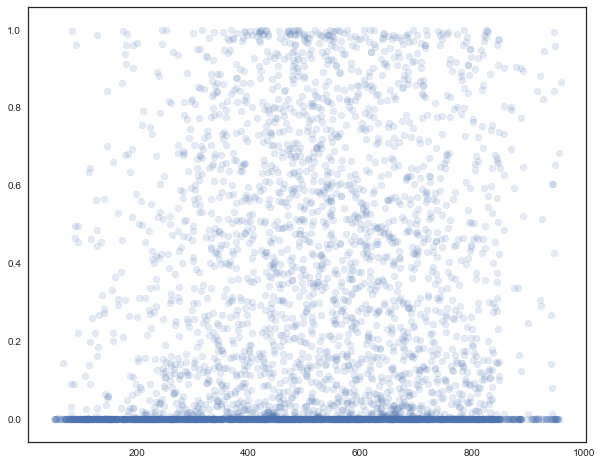

In [10]:
plt.figure(figsize=(10, 8))
plt.scatter(train_df.z, train_df.coverage, alpha=.15)
plt.show()

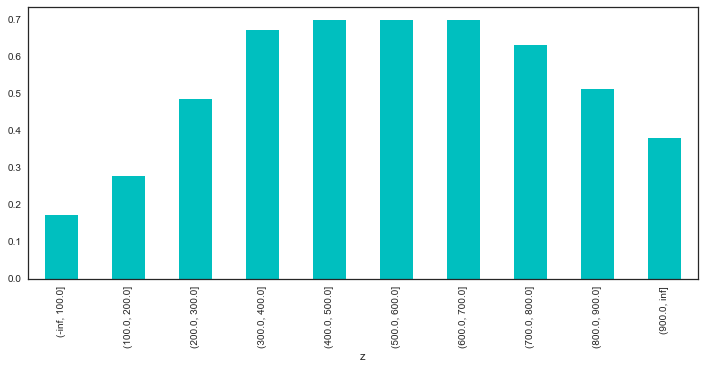

In [11]:
z_cut = pd.cut(train_df.z, [-np.Inf, 100, 200, 300, 400, 500, 600, 700, 800, 900, np.Inf])
c_cut = pd.cut(train_df.coverage, [-np.Inf, 0.0, .1, .2, .3, .4, .5, .6, .7, .8, .9, np.Inf], labels=range(11))
train_df["c1"] = (train_df.coverage > 0).astype("int")
train_df["z_cut"] = z_cut
train_df["c_cut"] = c_cut

z_group = train_df.groupby(z_cut)
(z_group.c1.sum() / z_group.c1.size()).plot(kind="bar", color="c", figsize=(12, 5))
plt.show()

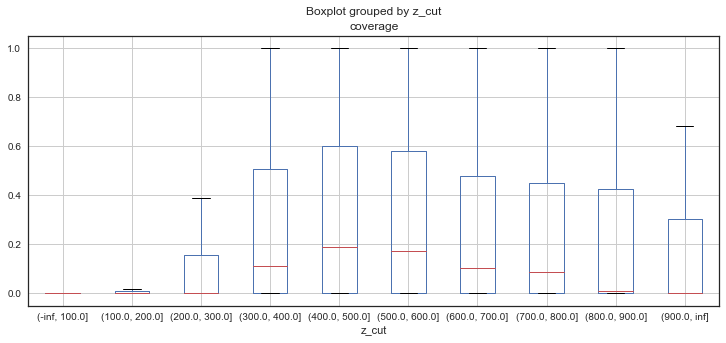

In [12]:
train_df.boxplot(column ="coverage", by="z_cut", figsize=(12, 5))

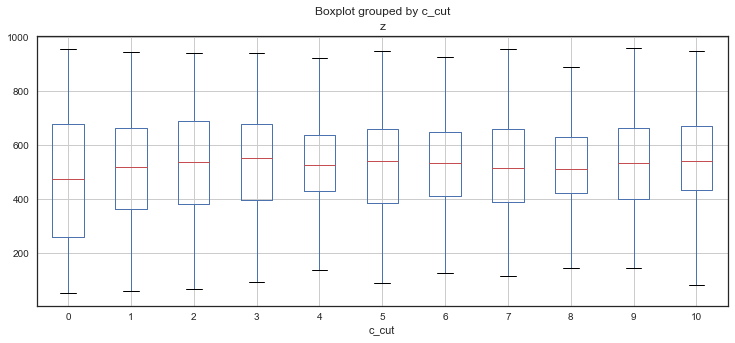

In [13]:
train_df.boxplot(column ="z", by="c_cut", figsize=(12, 5))

## 5fold-split --seed 123

In [14]:
from sklearn.model_selection import StratifiedKFold

In [15]:
X = np.array(train_df.images.tolist()).reshape(-1, img_size_target, img_size_target, 1)
Y = np.array(train_df.masks.tolist()).reshape(-1, img_size_target, img_size_target, 1)
y = train_df.c_cut.values.copy()

skf = StratifiedKFold(n_splits=5, random_state=123)
skf.get_n_splits(X, y)
kfold_index = [ob for ob in skf.split(X, y)]

y.shape

for train_idx, valid_idx in kfold_index:
    print(train_idx.shape, valid_idx.shape)

(3196,) (804,)
(3199,) (801,)
(3200,) (800,)
(3201,) (799,)
(3204,) (796,)


##  loss & metric

In [16]:
# code download from: https://github.com/bermanmaxim/LovaszSoftmax
def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard


# --------------------------- BINARY LOSSES ---------------------------

def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log, lab = flatten_binary_scores(log, lab, ignore)
            return lovasz_hinge_flat(log, lab)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """

    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        loss = tf.tensordot(tf.nn.relu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss,
                   strict=True,
                   name="loss"
                   )
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = tf.reshape(scores, (-1,))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return scores, labels
    valid = tf.not_equal(labels, ignore)
    vscores = tf.boolean_mask(scores, valid, name='valid_scores')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vscores, vlabels

def lovasz_loss(y_true, y_pred):
    y_true, y_pred = K.cast(K.squeeze(y_true, -1), 'int32'), K.cast(K.squeeze(y_pred, -1), 'float32')
    #logits = K.log(y_pred / (1. - y_pred))
    logits = y_pred #Jiaxin
    loss = lovasz_hinge(logits, y_true, per_image = True, ignore = None)
    return loss

In [17]:
def get_iou_vector(A, B):
    batch_size = A.shape[0]
    metric = []
    for batch in range(batch_size):
        t, p = A[batch]>0, B[batch]>0
#         if np.count_nonzero(t) == 0 and np.count_nonzero(p) > 0:
#             metric.append(0)
#             continue
#         if np.count_nonzero(t) >= 1 and np.count_nonzero(p) == 0:
#             metric.append(0)
#             continue
#         if np.count_nonzero(t) == 0 and np.count_nonzero(p) == 0:
#             metric.append(1)
#             continue
        
        intersection = np.logical_and(t, p)
        union = np.logical_or(t, p)
        iou = (np.sum(intersection > 0) + 1e-10 )/ (np.sum(union > 0) + 1e-10)
        thresholds = np.arange(0.5, 1, 0.05)
        s = []
        for thresh in thresholds:
            s.append(iou > thresh)
        metric.append(np.mean(s))

    return np.mean(metric)

def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred > 0], tf.float64)

def my_iou_metric_2(label, pred):
    return tf.py_func(get_iou_vector, [label, pred > .45], tf.float64)

## model

In [18]:
ACTIVATION = "relu"

def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    if activation == True:
        x = Activation(ACTIVATION)(x)
    return x

def se_block(blockInput, bottle=4):
    channel_cnt = int(blockInput.shape[-1])
    
    x = GlobalMaxPooling2D(data_format="channels_last")(blockInput)
    x = Dense(int(channel_cnt / bottle))(x)
    x = Activation("relu")(x)
    x = Dense(channel_cnt)(x)
    x = Activation("sigmoid")(x)
    x = Reshape((1, 1, channel_cnt))(x)
    x = Multiply()([blockInput, x])
    return x

def scse_block(blockInput, bottle=4):
    channel_cnt = int(blockInput.shape[-1])
    img_size = int(blockInput.shape[1])
    img_size2 = img_size * img_size

    x = GlobalMaxPooling2D(data_format="channels_last")(blockInput)
    x = Dense(int(channel_cnt / bottle))(x)
    x = Activation("relu")(x)
    x = Dense(channel_cnt, kernel_regularizer=l2(0.001))(x)
    x = Activation("sigmoid")(x)
    x = Reshape((1, 1, channel_cnt))(x)
    x = Multiply()([blockInput, x])
    
    y_pooling = (4, 4) if img_size % 2 == 1 else (2, 2)
    kernel_size = (5, 5) if img_size % 2 == 1 else (3, 3)
    padding = "valid" if img_size % 2 == 1 else "same"

    y = Conv2D(1, (1, 1), padding="same")(blockInput)
    # y = MaxPooling2D()(y)
    y = MaxPooling2D(y_pooling)(y)
    
    pool_size = int(y.shape[1])
    pool_size2 = pool_size * pool_size

    y = Reshape((pool_size2, ))(y)
    # print(y.shape)
    y = Dense(int(pool_size2 / bottle))(y)
    # print(y.shape)
    y = Activation("relu")(y)
    y = Dense(pool_size2, kernel_regularizer=l2(0.001))(y)
    # print(y.shape)

    y = Activation("sigmoid")(y)
    y = Reshape((pool_size, pool_size, 1))(y)

    # y = UpSampling2D()(y)
    # print(kernel_size, padding)
    y = Conv2DTranspose(1, kernel_size, strides=y_pooling, padding=padding)(y)
    y = Multiply()([blockInput, y])

    z = Add()([x, y])
    return z


def residual_block(blockInput, num_filters=16, use_se=False):
    x = Activation(ACTIVATION)(blockInput)
    x = BatchNormalization()(x)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    if use_se:
        x = scse_block(x)
    x = Add()([blockInput, x])
    return x

# Build model
def _build_model(input_layer, start_neurons, DropoutRatio = 0.5):
    # 101 -> 50
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(input_layer)
    conv1 = residual_block(conv1, start_neurons * 1)
    conv1 = residual_block(conv1, start_neurons * 1)
    conv1 = Activation(ACTIVATION)(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio/2)(pool1)

    # 50 -> 25
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(pool1)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = Activation(ACTIVATION)(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)

    # 25 -> 12
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(pool2)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = Activation(ACTIVATION)(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)

    # 12 -> 6
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(pool3)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = Activation(ACTIVATION)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm, start_neurons * 16, use_se=False)
    convm = residual_block(convm, start_neurons * 16, use_se=False)
    convm = Activation(ACTIVATION)(convm)
    
    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = Activation(ACTIVATION)(uconv4)
    
    # 12 -> 25
    #deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="valid")(uconv4)
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(DropoutRatio)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = Activation(ACTIVATION)(uconv3)

    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(DropoutRatio)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = Activation(ACTIVATION)(uconv2)
    
    # 50 -> 101
    #deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="valid")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(DropoutRatio)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 1, use_se=False)
    uconv1 = residual_block(uconv1,start_neurons * 1, use_se=False)
    uconv1 = Activation(ACTIVATION)(uconv1)
    
    # uconv1 = Dropout(DropoutRatio/2)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", name="final_conv")(uconv1)
    output_layer = Activation("sigmoid")(output_layer)
    
    return output_layer


def build_model(img_size_target):
    input_layer = Input((img_size_target, img_size_target, 2))
    output_layer = _build_model(input_layer, 16, 0.5)

    model = Model(input_layer, output_layer)
    # model.compile(loss="binary_crossentropy", optimizer="adam", metrics=[my_iou_metric_2])
    c = SGD(lr=0.01, momentum=.9, decay=1e-6)
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=[my_iou_metric_2])
    # model.compile(loss=lovasz_loss, optimizer=c, metrics=[my_iou_metric])
    return model

## model structure

In [19]:
model = build_model(101)

In [20]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 101, 101, 2)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 101, 101, 16) 304         input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 101, 101, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 101, 101, 16) 64          activation_1[0][0]               
__________________________________________________________________________________________________
conv2d_2 (

__________________________________________________________________________________________________
activation_10 (Activation)      (None, 50, 50, 32)   0           add_4[0][0]                      
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 25, 25, 32)   0           activation_10[0][0]              
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 25, 25, 32)   0           max_pooling2d_2[0][0]            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 25, 25, 64)   18496       dropout_2[0][0]                  
__________________________________________________________________________________________________
activation_11 (Activation)      (None, 25, 25, 64)   0           conv2d_11[0][0]                  
__________

add_8 (Add)                     (None, 12, 12, 128)  0           add_7[0][0]                      
                                                                 batch_normalization_24[0][0]     
__________________________________________________________________________________________________
activation_20 (Activation)      (None, 12, 12, 128)  0           add_8[0][0]                      
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 6, 6, 128)    0           activation_20[0][0]              
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 6, 6, 128)    0           max_pooling2d_4[0][0]            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 6, 6, 256)    295168      dropout_4[0][0]                  
__________

__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 12, 12, 128)  147584      activation_29[0][0]              
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 12, 12, 128)  512         conv2d_30[0][0]                  
__________________________________________________________________________________________________
add_12 (Add)                    (None, 12, 12, 128)  0           add_11[0][0]                     
                                                                 batch_normalization_36[0][0]     
__________________________________________________________________________________________________
activation_30 (Activation)      (None, 12, 12, 128)  0           add_12[0][0]                     
__________________________________________________________________________________________________
conv2d_tra

__________________________________________________________________________________________________
batch_normalization_46 (BatchNo (None, 50, 50, 32)   128         activation_38[0][0]              
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 50, 50, 32)   9248        batch_normalization_46[0][0]     
__________________________________________________________________________________________________
batch_normalization_47 (BatchNo (None, 50, 50, 32)   128         conv2d_39[0][0]                  
__________________________________________________________________________________________________
activation_39 (Activation)      (None, 50, 50, 32)   0           batch_normalization_47[0][0]     
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 50, 50, 32)   9248        activation_39[0][0]              
__________

 6,934,295

## add depth info

In [21]:
img_size = 101

def create_depth_figure(img_size):
    depth_figure = np.zeros((img_size, img_size))
    for i, d in enumerate(np.linspace(0, 1, img_size)):
        depth_figure[i, :] = d
    return depth_figure

In [22]:
depth_figure = create_depth_figure(101)

def append_depth_channel(img):
    global depth_figure
    shape = list(img.shape)
    shape[-1] = 2
    new_img = np.zeros(shape)
    new_img[:, :, 0] = img[:, : , 0]
    new_img[:, :, 1] = depth_figure
    return new_img

## train --fold 0

In [23]:
for i, (train_idx, valid_idx) in enumerate(kfold_index):
    # break
    print("fold:", i)
    print("index.shape:", train_idx.shape, valid_idx.shape)
    
    model_filepath = "{}-model-resnet-fold-{}.hdf5".format(exp_code, i)
    log_filepath = "{}-log-resnet-fold-{}.csv".format(exp_code, i)
    
    print("mode:", model_filepath)
    print("log:", log_filepath)
    metric_name = "val_my_iou_metric_2"

    early_stopping = EarlyStopping(monitor=metric_name, mode = 'max',patience=20, verbose=1)
    model_checkpoint = ModelCheckpoint(model_filepath, monitor=metric_name, mode = 'max', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor=metric_name, mode = 'max', factor=0.2, patience=10, min_lr=0.00001, verbose=1)
    model_logger = CSVLogger(log_filepath, separator=',', append=False)

    epochs = 200
    batch_size = 32
    
    X_train = X[train_idx, :]
    X_valid = X[valid_idx, :]
    Y_train = Y[train_idx, :]
    Y_valid = Y[valid_idx, :]
    
    X_train = np.append(X_train, [np.fliplr(x) for x in X_train], axis=0)
    X_train = np.array([append_depth_channel(x) for x in X_train])
    Y_train = np.append(Y_train, [np.fliplr(x) for x in Y_train], axis=0)
    X_valid = np.array([append_depth_channel(x) for x in X_valid])
    
    print("data.shape:", X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape)
    
    model = build_model(img_size_target=101)
    print("build model.")
    
    def train():
        return model.fit(X_train, Y_train,
                         validation_data=[X_valid, Y_valid], 
                         epochs=epochs,
                         batch_size=batch_size,
                         callbacks=[early_stopping, model_checkpoint, reduce_lr, model_logger], 
                         verbose=200)
    
    %time train()
    break

fold: 0
index.shape: (3196,) (804,)
mode: 023-model-resnet-fold-0.hdf5
log: 023-log-resnet-fold-0.csv
data.shape: (6392, 101, 101, 2) (6392, 101, 101, 1) (804, 101, 101, 2) (804, 101, 101, 1)
build model.
Train on 6392 samples, validate on 804 samples
Epoch 1/200

Epoch 00001: val_my_iou_metric_2 improved from -inf to 0.21405, saving model to 023-model-resnet-fold-0.hdf5
Epoch 2/200

Epoch 00002: val_my_iou_metric_2 improved from 0.21405 to 0.51555, saving model to 023-model-resnet-fold-0.hdf5
Epoch 3/200

Epoch 00003: val_my_iou_metric_2 improved from 0.51555 to 0.55908, saving model to 023-model-resnet-fold-0.hdf5
Epoch 4/200

Epoch 00004: val_my_iou_metric_2 did not improve from 0.55908
Epoch 5/200

Epoch 00005: val_my_iou_metric_2 improved from 0.55908 to 0.58060, saving model to 023-model-resnet-fold-0.hdf5
Epoch 6/200

Epoch 00006: val_my_iou_metric_2 improved from 0.58060 to 0.63632, saving model to 023-model-resnet-fold-0.hdf5
Epoch 7/200

Epoch 00007: val_my_iou_metric_2 did n

Epoch 00089: val_my_iou_metric_2 improved from 0.78246 to 0.78806, saving model to 023-model-resnet-fold-0.hdf5
Epoch 90/200

Epoch 00090: val_my_iou_metric_2 did not improve from 0.78806
Epoch 91/200

Epoch 00091: val_my_iou_metric_2 did not improve from 0.78806
Epoch 92/200

Epoch 00092: val_my_iou_metric_2 did not improve from 0.78806
Epoch 93/200

Epoch 00093: val_my_iou_metric_2 improved from 0.78806 to 0.78881, saving model to 023-model-resnet-fold-0.hdf5
Epoch 94/200

Epoch 00094: val_my_iou_metric_2 did not improve from 0.78881
Epoch 95/200

Epoch 00095: val_my_iou_metric_2 did not improve from 0.78881
Epoch 96/200

Epoch 00096: val_my_iou_metric_2 did not improve from 0.78881
Epoch 97/200

Epoch 00097: val_my_iou_metric_2 did not improve from 0.78881
Epoch 98/200

Epoch 00098: val_my_iou_metric_2 did not improve from 0.78881
Epoch 99/200

Epoch 00099: val_my_iou_metric_2 did not improve from 0.78881
Epoch 100/200

Epoch 00100: val_my_iou_metric_2 did not improve from 0.78881
E

## finetune --fold 0

In [141]:
def load_pretrained_model(filename):
    co = {
        "my_iou_metric_2": my_iou_metric_2
    }
    model_pretrained = load_model(filename, custom_objects=co)
    
    model_rebuild = Model(model_pretrained.layers[0].input, model_pretrained.layers[-1].input)
    
    c = SGD(lr=0.001)
    model_rebuild.compile(loss=lovasz_loss, optimizer=c, metrics=[my_iou_metric])
    return model_rebuild

In [143]:
for i, (train_idx, valid_idx) in enumerate(kfold_index):
    # break
    print("fold:", i)
    print("index.shape:", train_idx.shape, valid_idx.shape)
    
    model_filepath = "{}-model-resnet-fold-{}.hdf5".format(exp_code, i)
    model_finetune0_filepath = "{}-model-resnet-finetune0-fold-{}.hdf5".format(exp_code, i)
    log_finetune0_filepath = "{}-log-resnet-finetune0--fold-{}.csv".format(exp_code, i)

    
    print("mode:", model_filepath)
    print("model finetune0:", model_finetune0_filepath)
    print("log:", log_finetune0_filepath)
    metric_name = "val_my_iou_metric"

    early_stopping = EarlyStopping(monitor=metric_name, mode = 'max',patience=30, verbose=1)
    model_checkpoint = ModelCheckpoint(model_finetune0_filepath, monitor=metric_name, mode = 'max', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor=metric_name, mode = 'max', factor=0.2, patience=10, min_lr=0.00001, verbose=1)
    model_logger = CSVLogger(log_finetune0_filepath, separator=',', append=False)

    epochs = 200
    batch_size = 32
    
    X_train = X[train_idx, :]
    X_valid = X[valid_idx, :]
    Y_train = Y[train_idx, :]
    Y_valid = Y[valid_idx, :]
    
    X_train = np.append(X_train, [np.fliplr(x) for x in X_train], axis=0)
    X_train = np.array([append_depth_channel(x) for x in X_train])
    Y_train = np.append(Y_train, [np.fliplr(x) for x in Y_train], axis=0)
    X_valid = np.array([append_depth_channel(x) for x in X_valid])

    print("data.shape:", X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape)
    
    model_rebuild = load_pretrained_model(model_filepath)
    print("build model.")
    
    def train():
        return model_rebuild.fit(X_train, Y_train,
                                 validation_data=[X_valid, Y_valid], 
                                 epochs=epochs,
                                 batch_size=batch_size,
                                 callbacks=[early_stopping, model_checkpoint, reduce_lr, model_logger], 
                                 verbose=200)
    
    %time train()
    break

fold: 0
index.shape: (3196,) (804,)
mode: 022-model-resnet-fold-0.hdf5
model finetune0: 022-model-resnet-finetune0-fold-0.hdf5
log: 022-log-resnet-finetune0--fold-0.csv
data.shape: (6392, 101, 101, 2) (6392, 101, 101, 1) (804, 101, 101, 2) (804, 101, 101, 1)
build model.
Train on 6392 samples, validate on 804 samples
Epoch 1/200

Epoch 00001: val_my_iou_metric improved from -inf to 0.76604, saving model to 022-model-resnet-finetune0-fold-0.hdf5
Epoch 2/200

Epoch 00002: val_my_iou_metric improved from 0.76604 to 0.76853, saving model to 022-model-resnet-finetune0-fold-0.hdf5
Epoch 3/200

Epoch 00003: val_my_iou_metric improved from 0.76853 to 0.76928, saving model to 022-model-resnet-finetune0-fold-0.hdf5
Epoch 4/200

Epoch 00004: val_my_iou_metric improved from 0.76928 to 0.77077, saving model to 022-model-resnet-finetune0-fold-0.hdf5
Epoch 5/200

Epoch 00005: val_my_iou_metric did not improve from 0.77077
Epoch 6/200

Epoch 00006: val_my_iou_metric improved from 0.77077 to 0.77251, s